# Вводные

Были даны уровни российских и американских процентных ставок на 01.01.2019, а также соответствующие значения $\textit{mean reversion level}$ (среднее значение, к которому возвращается наш риск-фактор и которое выводится из кривой процентных ставок), $\alpha$ (скорость возвращения к среднему) и $\sigma$ (волатильность, или стандартное отклонение прироста процентной ставки) для модели Халла-Уайта. С помощью формулы 

$$F = S_0\frac{1+r_f}{1+r_d}$$

мы также могли получить динамику обменного курса.

# Задача

1. Оценить матрицу корреляций для наших вводных процентных ставок и обменного курса.
2. С помощью разложения Холецкого сгенерировать 3 соответствующих гауссовских вектора риск-факторов с заданным распределением.
3. Оценить максимальный скачок для приращений риск-факторов.
4. При симуляциях оценить разность 95% квантилей и получить некий уровень точности, и оценить его экспертно.

# Шаги

1. Современные финансовые рынки предлагают множество финансовых инструментов, которые при правильной оценке и использовании могут помочь минимизировать уровень риска. Для оценки финансовых инструментов широко используются модели, одной из самых популярных на данный момент является модель Блэка-Шоулза. Однако модель Блэка-Шоулза обладает рядом ограничений – она работает в предположении постоянной волатильности и уровня процентных ставок.  
2. Для более точной оценки флуктуаций процентных ставок можно применить модель временной структуры процентных ставок Халла-Уайта (которая является расширенной версией модели Васичека), где параметры $\alpha(t)$ и $\sigma(t)$ зависят от времени:

    $$dr = [\theta(t) – \alpha(t)r]dt + \sigma(t)dW,$$
    где $\theta (t) = \frac{df(t,T)}{dt} + \alpha f(t,T) + \frac{(1- e^{-2\alpha t}) \sigma^2}{2\alpha}$ обеспечивает точное соответствие модели и наблюдаемой на рынке структуры процентных ставок, $f(t,T)$ - форвардная ставка процента.

    Функция $\theta(t)$ является прямым решением СДУ и обеспечивает точное соответствие модели и наблюдаемой на рынке структуры процентных ставок.
    Для оценки флуктуаций обменного курса воспользуемся следующей формулой:
    
    $$\frac{dX_t}{X_t} = k(\theta - \ln X_t)dt + \sigma_{FX}(t)dW_t.$$


In [1]:
import numpy as np
import pandas as pd
import numpy.linalg as linalg
import matplotlib.pyplot as plt
import numpy.linalg as linalg
from scipy.interpolate import CubicSpline

In [2]:
# Provided data
weeks_in_month = (365/7)*(1/12)
maturity_rub = [3,6,9,12,24,36,48,60,72,84,96,108,120,144,180,]
maturity_rub= [i * weeks_in_month for i in maturity_rub]

ds_rate_rub = [
    8.51987757,
    8.68611319,
    8.90460383,
    9.04938647,
    9.16620517,
    9.16277249,
    9.119128,
    9.06260294,
    9.01015779,
    8.95942704,
    8.91830151,
    8.87442665,
    8.83969915,
    8.8362406,
    8.79850223,]

maturity_usd = [3,6,9,12,15,18,21,24,27,30,33,36,39,48,60,72,84,96,108,120,132,144,180,240,300,360]
maturity_usd= [i * weeks_in_month for i in maturity_usd]
ds_rate_usd = [
    2.84253062,
    2.80778295,
    2.7947691,
    2.78672186,
    2.78148933,
    2.76474858,
    2.74385753,
    2.72299332,
    2.70750966,
    2.69278142,
    2.68063008,
    2.67150303,
    2.66686195,
    2.66005416,
    2.67045368,
    2.68499512,
    2.70525985,
    2.72994097,
    2.75619769,
    2.78172399,
    2.804673,
    2.82275184,
    2.857914,
    2.87560338,
    2.86786144,
    2.85316361]

In [3]:
# Prepare base rate curves

def get_rates():

    interpolate_rub = CubicSpline(maturity_rub, ds_rate_rub)
    interpolate_usd = CubicSpline(maturity_usd, ds_rate_usd)

    interval_rub = np.arange(0, 54, 2)
    interval_usd = np.arange(0, 54, 2)

    df_rub_int = pd.DataFrame(data={'maturity_rub_2weeks': interval_rub, 'rub_act': interpolate_rub(interval_rub)})
    df_usd_int = pd.DataFrame(data={'maturity_usd_2weeks': interval_usd, 'usd_act': interpolate_usd(interval_usd)})


    df_rub_usd_int=pd.concat([df_usd_int, df_rub_int], axis=1, sort=False)
    df_rub_usd_int=df_rub_usd_int.drop(['maturity_rub_2weeks'], axis=1)
    df_rub_usd_int=df_rub_usd_int.rename(columns={"maturity_usd_2weeks":"maturity"})
    df_rub_usd_int['maturity_frac'] = df_rub_usd_int['maturity']/54

    # s=0.0134
    s=1/0.01442

    new_rates = pd.concat(
        [
            df_rub_usd_int,
            df_rub_usd_int.diff(1).rename(columns={x:x.replace('act','diff') for x in df_rub_usd_int.columns})
        ],
        axis=1)

    new_rates.fillna(0, inplace=True)
    new_rates['fx_act']=(s*(1+new_rates['usd_act']*0.01)/(1+new_rates['rub_act']*0.01))
    new_rates['fx_diff'] =new_rates['fx_act'].diff()


    curve_rub_act = new_rates.loc[1:,'rub_act']
    curve_usd_act = new_rates.loc[1:,'usd_act']
    curve_fx_act = new_rates.loc[1:,'fx_act']

    curve_rub_diff = new_rates.loc[1:,'rub_diff']
    curve_usd_diff = new_rates.loc[1:,'usd_diff']
    curve_fx_diff = new_rates.loc[1:,'fx_diff']
    init = new_rates.loc[0,['rub_act','usd_act','fx_act']]


    return  (
        curve_rub_act,
        curve_usd_act,
        curve_fx_act,
        curve_rub_diff,
        curve_usd_diff,
        curve_fx_diff,
        init)

In [ ]:
# Prepare stochastic correlations from risk-factors correlations and Choletsky decomposition
def get_decomp():

    fx_raw = pd.read_html('./fx_rates.html')[0]
    fx_raw.columns = [', '.join(x[1:]) for x in fx_raw.columns]
    fx=fx_raw.iloc[:,[0,3]]
    fx.columns = ['date','fx_rate']
    fx.loc[:,'date']=pd.to_datetime(fx['date'], format="%d/%m/%Y")
    fx=fx.sort_values(by='date').reset_index(drop=True)

    rub_irs_raw = pd.read_excel('ROISfix history.xlsx')
    rub_irs=rub_irs_raw.loc[:,['Дата ставки','3M']]
    rub_irs.columns=['date','rub_rate']
    rub_irs.loc[:,'date'] = pd.to_datetime(rub_irs['date'], format="%d-%m-%Y")
    rub_irs = rub_irs.sort_values(by='date').reset_index(drop=True)

    usd_irs_raw = pd.read_excel('./LIBOR USD history.xlsx')
    usd_irs=usd_irs_raw.loc[:,['Date','3M']]
    usd_irs.columns=['date','usd_rate']
    usd_irs.loc[:,'date'] = pd.to_datetime(usd_irs['date'], format="%d.%m.%Y")
    usd_irs = usd_irs.sort_values(by='date').reset_index(drop=True)

    mrg = pd.merge(
        rub_irs,
        pd.merge(
            usd_irs,
            fx,
            left_on='date',
            right_on='date',
            how='outer'

        ),
        left_on='date',
        right_on='date',
        how='outer'
    )

    merged_interpolated_diff_corr = mrg.interpolate(method='linear').iloc[3:,1:].diff().iloc[1:].corr()
    decomposed = linalg.cholesky(merged_interpolated_diff_corr)
    return decomposed

# Предобработка данных

Для получения значений процентных ставок с интервалом в 2 недели на годовом горизонте мы использовали метод линейной интерполяции и получили следующие значения и кривые: #вставить графики Нади

Получение данных для матрицы корреляций:
Получив на предыдущем шаге точные процентные ставки, и, соответственно, обменный курс по формуле, мы можем получить корреляционную матрицу наших риск-факторов 
Получение совместной корреляции
Для прогнозирования наших риск факторов на год, мы используем совместную генерацию процентных ставок и обменного курса с помощью разложения Холецкого:

# Математическое описание алгоритма

### Исходные данные:
положительно определённая симметрическая  матрица $A$ (элементы $a_{ij}$).

### Вычисляемые данные:
нижняя треугольная матрица $L$ (элементы $l_{ij}$).
### Формулы метода:
$$l_{11} = \sqrt{a_{11}},$$
$$l_{j1} = \frac{a_{j1}}{l_{11}}, j \in [2,n]$$
$$l_{ii} = \sqrt{a_{ii} - \sum^{i-1}_{p=1}{l^2_{ip}}}, i \in [2,n]$$
$$l_{ji} = \frac{\big( a_{ji} - \sum^{i-1}_{p=1}{l_{ip} l_{jp}} \big)}{l_{ii}}, i \in [2,n-1], j \in [i+1,n]$$


In [ ]:
instruments=['usd','rub','fx']


def stoch_wrapper(decomp):
    def make_stoch(num):
        sigma=[0.03, 0.0093, 0.11]
        stoch_generator = np.dot(np.random.normal(size=(num,3)),decomp)*sigma
        return stoch_generator
    return make_stoch


stoch_generator = stoch_wrapper(get_decomp())


#Simulation routine

def simulate_hull_white(
    sim_number = 10,):
    rub_alpha=0.03
    usd_alpha=0.02
    sigma=[0.03, 0.0093, 0.11]
    k_fx=0.015
    dt=14/365
    timesteps = 26

    (
        curve_rub,
        curve_usd,
        curve_fx,
        curve_rub_df,
        curve_usd_df,
        curve_fx_df,
        init
        ) = get_rates()


    results = np.zeros(shape=(timesteps+1, 3, sim_number))

    passed_time=0

    for sim_ix in range(sim_number):
        results[0,:,sim_ix] = init
        stochs = stoch_generator(timesteps+1)
        for i, (rate_rub, rate_usd, rate_fx,df_rub, df_usd,df_fx, stoch_tuple) in enumerate(zip(curve_rub,curve_usd,curve_fx,curve_rub_df,curve_usd_df, curve_fx_df, stochs)):
            passed_time+=dt

            theta_rub = df_rub + rub_alpha*rate_rub + (sigma[0]**2)*(1-np.exp(-2*rub_alpha*passed_time))/2*rub_alpha
            theta_usd = df_usd + usd_alpha*rate_usd + (sigma[1]**2)*(1-np.exp(-2*usd_alpha*passed_time))/2*usd_alpha

            results[i+1,0,sim_ix] = (theta_rub - rub_alpha* results[:,0,sim_ix].sum())*dt+stoch_tuple[0]
            results[i+1,1,sim_ix] = (theta_usd - usd_alpha* results[:,1,sim_ix].sum())*dt+stoch_tuple[1]
            results[i+1,2,sim_ix] = k_fx*(rate_fx - np.log( results[:,2,sim_ix].sum()))*dt+stoch_tuple[2]

    return results



def plot_results(result, show_diffs=True):
    fig,ax = plt.subplots(2,3,figsize=(25,12))
    titles=['Процентная ставка в рублях, приращения', "Процентная ставка в доларах, приращения", "Обменный курс, приращения"]
    for i in range(3):
        ax[0][i].plot(result[1:,i,:], alpha=0.1)
        ax[0][i].plot(np.quantile(result[1:,i,:], q=0.95, axis=1))
        ax[0][i].set_xlabel('Шаг симуляции')



        ax[0][i].set_title(titles[i]+ f'\nVaR 95%\nmax = {round(np.quantile(result[1:,i,:], q=0.95, axis=1).max(), 4)}')
    titles=['Процентная ставка в рублях', "Процентная ставка в доларах", "Обменный курс"]
    for i in range(3):
        ax[1][i].plot(result[:,i,:].cumsum(axis=0), alpha=0.1)
        ax[1][i].set_title(titles[i])
        ax[1][i].set_xlabel('Шаг симуляции')

    plt.show()

# Прогонка модели
На данном этапе мы симулируем модель Халла-Уайта одновременно для всех трех риск факторов. Для каждого фактора используем предыдущие значения r, посчитанную по формуле θ, заданные значения α и полученные при разложении Холецкого σ, а также геометрическое броуновское движение. 
Для начального уровня обменного курса берем рыночную цену на 01.01.2019, которая равна 69,7267. 
__#вставить графики с риск факторами__


In [ ]:
def perform_simulations_basic_mode(sim_number=1000):
    results = simulate_hull_white(sim_number=sim_number)
    # results - np array of shape(no of timesteps, no of instruments, no of simulations)
    plot_results(results)
    return results

def analyze_optimal_sim_num():
    sim_nums = np.linspace(100,100000,51)
    quantiles = {}
    raw = {}
    for sim in sim_nums:
        local_result = simulate_hull_white(int(sim))
        max_quantiles = np.quantile(local_result[1:,:,:],q=0.95,axis=2).max(axis=0)
        quantiles[int(sim)]=max_quantiles
        raw[int(sim)]=local_result

    df = pd.DataFrame(quantiles).T#.diff().abs().plot()
    df.rename(columns={0:'RUB',1:'USD',2:'FX'}, inplace=True)
    fig, axes=plt.subplots(ncols=2, figsize=(15,9))
    df.plot(title='Значение 95% VaR приращений',ax=axes[0])
    df.diff().abs().plot(title='Модуль дельты значения 95% VaR приращений',ax=axes[1])
    axes[0].set_ylabel('Значение VaR')
    axes[1].set_ylabel('Отличие VaR при повышении количества итераций')
    axes[0].set_xlabel('Количество симуляций')
    axes[1].set_xlabel('Количество симуляций')

    plt.show()
    return quantiles, raw

# VaR

Поскольку нас интересует не только динамика процентных ставок и обменного курса, но и то, как это повлияет на стоимость наших финансовых инструментов, мы оцениваем вероятность шока на рынке. Для данного мы считаем 95-процентный квантиль приращения риск факторов на каждой двухнедельной итерации симуляционного блока и среди этих квантилей выбрать максимум. __#вставить графики с VaR__

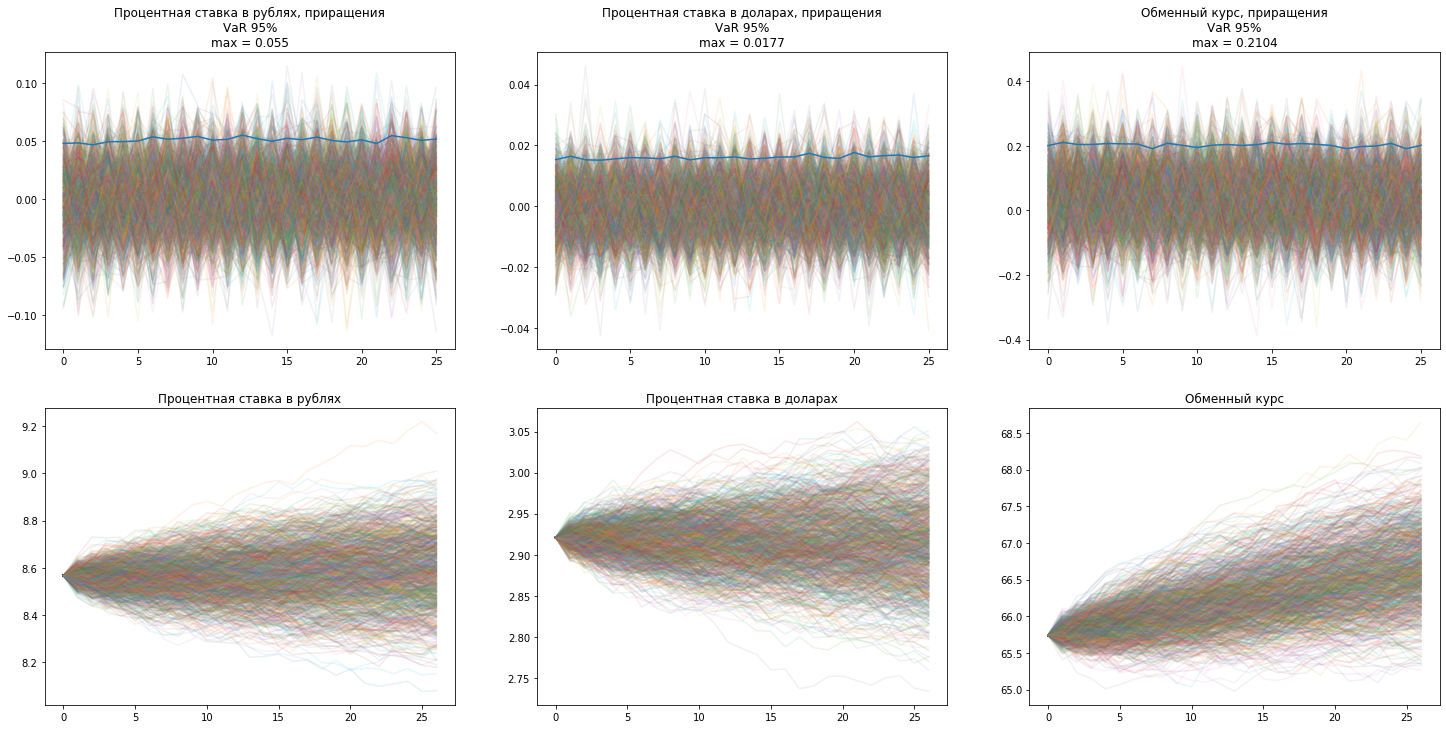

In [7]:
quant, results = analyze_optimal_sim_num()

# Оценка точности
Для того, чтобы верно оценить максимум среди 95% VaR, мы наращиваем количество симуляций изменений 95% VaR приращений. По нашей модели, мы задали точность $\varepsilon=0.0025$, что дало нам количество необходимых симуляций равное ___. #вставить финальное значение__

# Вывод

Построив модель Халла-Уайта для российской ставки процента, американской ставки процента и соответствующего обменного курса, мы пришли к выводу, что по состоянию на 01.01.2019 участники рынка закладывали рост обменного курса, то есть прогнозировали рост курса доллара выше 69 рублей. Это можно увидеть на графиках – на симуляции обменного курса видно, что среднее значение на годовом временном горизонте выросло. Зная данные на 31.12.2019 мы можем сказать, что данные прогнозы не сбылись и курс доллара упал до 62 рублей. Это не значит, что модель не работает, это значит, что модель оценивает ожидания, закладываемые рынком на будущее и работает настолько хорошо, насколько хорошо участники рынка предсказывают будущее.